In [1]:
include("../ToolBox/ToolBox.jl")
import FileIO
import JLD
using .ToolBox
using .Geometry
using Colors

In [2]:
function moasic2normal_view(moasic_view,meta)
    @assert moasic_view[1].start >= meta["burst_meta"]["first_line_mosaic"][1]
    @assert moasic_view[1].stop <= (meta["burst_meta"]["first_line_mosaic"][end] + meta["lines_per_burst"])

    
    start_burst = findlast(
    meta["burst_meta"]["first_line_mosaic"].<= moasic_view[1].start)

    lines_in_first_burst = moasic_view[1].start -meta["burst_meta"]["first_line_mosaic"][start_burst] +1
    line_start = lines_in_first_burst + (start_burst-1)* meta["lines_per_burst"]

    end_burst = 0
    if moasic_view[1].stop < meta["lines_per_burst"]
        end_burst = 1
    else
        end_burst = findlast(
            (meta["burst_meta"]["first_line_mosaic"] .+meta["lines_per_burst"] ).< moasic_view[1].stop)+1
    end

    lines_in_last_burst =  moasic_view[1].stop - meta["burst_meta"]["first_line_mosaic"][end_burst] +1
    line_end = lines_in_last_burst+ (end_burst-1)* meta["lines_per_burst"]
    return [line_start:line_end,moasic_view[2]]
end


function round_2_int(float_number,tol=0.1)
    res = round(Int64,float_number)
    @assert abs(res-float_number)<tol "Rounding not within tolerance"
return res
end

using Dates
function split_large_view(large_view,meta_first,meta_second)
    c = 299792458
    azimuth_frequency =  meta_first["azimuth_frequency"]
    inv_range_pixel_spacing = (2*meta_first["range_sampling_rate"])/c
    delta_r0 = (meta_second["slant_range_time"]-meta_first["slant_range_time"])*c/2
    delta_sample = inv_range_pixel_spacing*delta_r0

    delta_sample = round_2_int(inv_range_pixel_spacing*delta_r0)

    over_lap = meta_first["samples_per_burst"]-delta_sample +1

    delta_minus = 300
    delta_plus = over_lap - delta_minus


    view_first = large_view[1],large_view[2].start:(meta_first["samples_per_burst"]-delta_minus)

    mosaic_view_first = SlcUtil.get_mosaic_view(meta_first,view_first)


    detlta_t0 = convert(Second,(meta_first["t_0"]-meta_second["t_0"]) ).value

    line_t_first_start =  (mosaic_view_first[1].start-1)/azimuth_frequency+meta_first["t_start"]
    line_second_start = round_2_int(1 + ((line_t_first_start+detlta_t0)-meta_second["t_start"])*azimuth_frequency)

    line_t_first_stop =  (mosaic_view_first[1].stop-1)/azimuth_frequency+meta_first["t_start"]
    line_second_stop= round_2_int(1 + ((line_t_first_stop+detlta_t0)-meta_second["t_start"])*azimuth_frequency)


    mosaic_view_second = [line_second_start:line_second_stop,
                        (1+delta_plus): (large_view[2].stop - delta_sample+1)]
    
    delta_line =  round_2_int( mosaic_view_first[1].start-mosaic_view_second[1].start)

    view_second = moasic2normal_view(mosaic_view_second,meta_second)
    return view_first,view_second,delta_line,delta_sample
end

split_large_view (generic function with 1 method)

In [4]:
function _meta_cal_datapath_pod(product_folders,polarization,subswath,pod_folder)
    
    file_paths = [Load.slc_paths(folder, polarization, subswath) for folder in product_folders]
    meta = [Load.slc_meta(path[2]) for path in file_paths]
    calibration = [Load.slc_calibration(file_paths[i][3],meta[i]["t_0"]) 
                            for i in 1:length(product_folders)];
    data_path = [path[1] for path in file_paths]
    
    pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
    
    precise_orbit = [Load.precise_orbit(pod_paths[i],meta[i]["t_0"]) 
                            for i in 1:length(product_folders)]
    
    return meta, calibration, data_path ,precise_orbit
end


function _get_dem(meta,view,dem_path,nan_fill)
    footprint = SlcUtil.footprint(meta[1], view)
    latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
    dem = 0 
    if split(dem_path,".")[end] == "jld"
        pad = 0.1
        dem = JLD.load(dem_path);
        idx1 =(latlon_window[1][1] - pad) .<dem["lat"].< (latlon_window[1][2] + pad)
        idx2 =(latlon_window[2][1] - pad) .<dem["lon"].< (latlon_window[2][2] + pad)
        dem = (dem["lat"][idx1], dem["lon"][idx2], dem["height"][idx1,idx2]);
        dem[3][dem[3].== -32768] .= nan_fill
    elseif split(dem_path,".")[end] == "tiff"
        dem = Load.dem(dem_path, latlon_window; nan_fill = nan_fill, padding=[90,90]);
    else
        @assert 1==2 "DEM format not reconised"
    end
    return dem 
end


function _slave_load_data(master_view,data_path,meta, precise_orbit,dem,calibration)
    slave_data,flat,lut =  coregister_slave(master_view,
                                                data_path[2],
                                                meta, precise_orbit, dem)  # meta should be 2 Dict array
    slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
    flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);
    slave_data = SlcUtil.calibrate_slave_data(slave_data, mosaic_view, lut, calibration[2]);
    return slave_data,flat,lut, mosaic_view
end

function _master_load_data(master_view,data_path,meta,calibration)
    master_data = Load.slc_data(data_path[1], master_view);
    master_data ,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);
    master_data = SlcUtil.calibrate_data(master_data, Misc.flatten(mosaic_view...)..., calibration[1]);
    return master_data,mosaic_view
end


function _geo_lut_combi(lut_first,lut_second,delta_line,delta_sample,mosaic_view)
    lut_sample_strid = lut_first["master_sample"][2]-lut_first["master_sample"][1]
    sample_new_start = lut_first["master_sample"][end]+lut_sample_strid
    sample_new_temp = collect(sample_new_start :lut_sample_strid:  mosaic_view[2].stop);
    
    
    geo_lut  = Dict{String,Any}()
    geo_lut["master_sample"] =  cat(lut_first["master_sample"],sample_new_temp,dims=1)
    geo_lut["master_line"] =  lut_first["master_line"]

    row_second = lut_first["master_line"].-delta_line;
    col_second  = sample_new_temp.-delta_sample;
    
    dims_lut_first = (length(lut_first["master_line"]),length(lut_first["master_sample"]))
    dims_lut_second = (length(lut_second["master_line"]),length(lut_second["master_sample"]))
    dims_lut_new = (length(row_second),length(col_second))
    
    key_list = ["latitude","longitude","heights"]
    
    for key in key_list
        old_second = reshape(lut_second[key],dims_lut_second)
        new_second = Misc.interp_grid(lut_second["master_line"] ,lut_second["master_sample"],
                                                        old_second,row_second, col_second)
        commbined = hcat(reshape(lut_first[key],dims_lut_first),new_second)
        geo_lut[key] = commbined
    
    end
        
    return geo_lut
end

function _geo_lut!(lut)
    
    dims_lut = (length(lut["master_line"]),length(lut["master_sample"]))
    key_list = ["latitude","longitude","heights"]
    
    for key in key_list
        lut[key] = reshape(lut[key],dims_lut)
    end
    delete!(lut, "slave_line")
    delete!(lut, "slave_sample")
    
    return lut
end

function _get_data_mosaic_swaths(meta, calibration, data_path ,precise_orbit,
                                    product_folders, master_view, dem_path, 
                                  subswath, dem_nan, polarization)
    
    @assert subswath<3 "The view is outside the image"
    sec_meta,sec_calibration,sec_data_path, sec_precise_orbit = _meta_cal_datapath_pod(
                                                product_folders,polarization,subswath+1,pod_folder);

    view_first,view_second,delta_line,delta_sample = split_large_view(master_view,meta[1],sec_meta[1])

    dem_first = _get_dem(meta,view_first,dem_path,dem_nan)
    dem_second = _get_dem(sec_meta,view_second,dem_path,dem_nan);

    data_slave_first, flat_first, 
    lut_first, mosaic_view_first = _slave_load_data(view_first,data_path,meta, 
                                            precise_orbit,dem_first,calibration);

    data_slave_second, flat_second, 
    lut_second, mosaic_view_second = _slave_load_data(view_second,sec_data_path,sec_meta, 
                                            sec_precise_orbit,dem_second ,sec_calibration);


    master_data_first,temp = _master_load_data(view_first,data_path,meta,calibration)
    master_data_second,temp = _master_load_data(view_second,sec_data_path,sec_meta,sec_calibration)

    master_data = hcat(master_data_first,master_data_second);
    slave_data = hcat(data_slave_first,data_slave_second);
    flat =  hcat(flat_first,flat_second);

    mosaic_view = [mosaic_view_first[1],
                master_view[2]]

    geo_lut = _geo_lut_combi(lut_first,lut_second,delta_line,delta_sample,mosaic_view)


    return master_data, slave_data, flat, mosaic_view, geo_lut
end


function _get_data_single_swaths(meta, calibration, data_path ,precise_orbit,
                                    product_folders, master_view, dem_path, 
                                    dem_nan)

    dem = _get_dem(meta,master_view,dem_path,dem_nan)

    slave_data, flat, 
    lut, mosaic_view = _slave_load_data(master_view,data_path,meta, 
                                        precise_orbit,dem,calibration);


    master_data,temp = _master_load_data(master_view,data_path,meta,calibration)

    geo_lut = _geo_lut!(lut)

    return master_data, slave_data, flat, mosaic_view, geo_lut
end

_get_data_single_swaths (generic function with 1 method)

In [31]:
function coherence_worker(product_folders, master_view, dem_path, 
                          subswath, dem_nan, pod_folder, polarization; 
                          kernel = ones(4,14))
    
    stride_line = floor(Int,size(kernel)[1]/2)
    stride_sample = floor(Int,size(kernel)[2]/2)

    meta, calibration, data_path ,precise_orbit = _meta_cal_datapath_pod(
                                                product_folders,polarization,subswath,pod_folder);

    # initiliazise varibles
    master_data, slave_data,
    flat, mosaic_view, geo_lut = Nothing,Nothing,Nothing,Nothing,Nothing


    if meta[1]["samples_per_burst"] < master_view[2].stop 
        master_data, slave_data,
        flat, mosaic_view, geo_lut = _get_data_mosaic_swaths(meta, calibration, data_path 
            ,precise_orbit,product_folders, master_view, dem_path,
            subswath, dem_nan, polarization)
    else
        master_data, slave_data,
        flat, mosaic_view, geo_lut = _get_data_single_swaths(meta, calibration, data_path ,precise_orbit,
                                        product_folders, master_view, dem_path, 
                                        dem_nan)
    end;


    complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(
                        master_data, slave_data, flat, kernel, mosaic_view);


    # Subsample 
    lines = lines[1:stride_line:end]
    samples = samples[1:stride_sample:end]
    master_intensity = master_intensity[1:stride_line:end,1:stride_sample:end]
    slave_intensity = slave_intensity[1:stride_line:end,1:stride_sample:end]
    complex_coherence = complex_coherence[1:stride_line:end,1:stride_sample:end]

    # Check that the size matches
    @assert length(master_intensity) > 0
    @assert sum(size(master_intensity) .== size(complex_coherence)) ==2
    @assert sum(size(slave_intensity) .== size(complex_coherence)) == 2
    @assert size(master_intensity)[1] == length(lines)
    @assert size(master_intensity)[2] == length(samples)

    return complex_coherence, master_intensity, slave_intensity, lines, samples, geo_lut
end

coherence_worker (generic function with 1 method)

In [34]:
1+1

2

# Coherence Worker

In [13]:
master_folder = "/home/data/simon/data/117_jutlandS_autumn2019/S1A_IW_SLC__1SDV_20190929T170932_20190929T170959_029239_035263_C3F9.SAFE"
slave_folder = "/home/data/simon/data/117_jutlandS_autumn2019/S1A_IW_SLC__1SDV_20191011T170932_20191011T170959_029414_035865_06AB.SAFE"

#dem

product_folders= [master_folder,slave_folder]
master_view = [8004:10200,18000:30000]

#master_view = [8004:10200,14000:20000]
dem_path = "/home/data/simon/DEM/denmark.jld";
subswath =2 
dem_nan = 40
pod_folder = "/home/data/simon/POE"
polarization = "VV"
kernel = ones(4,14);

In [14]:
complex_coherence, master_intensity, 
slave_intensity,lines, samples, geo_lut = coherence_worker(product_folders, master_view, dem_path, 
                                              subswath, dem_nan, pod_folder, polarization);

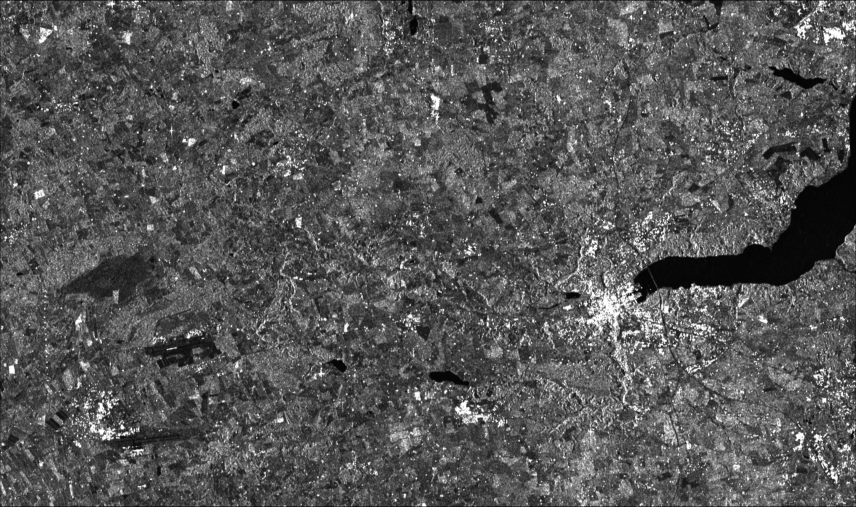

In [15]:
SlcUtil.show_img(master_intensity)

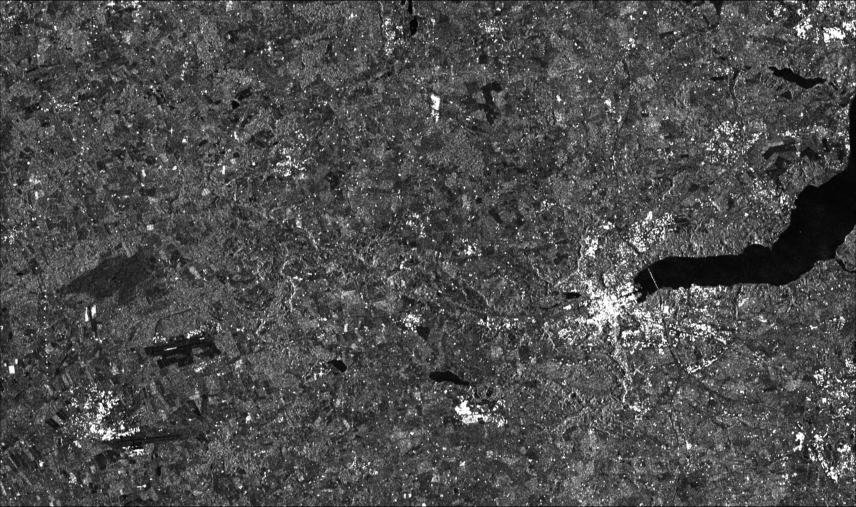

In [33]:
SlcUtil.show_img(slave_intensity)

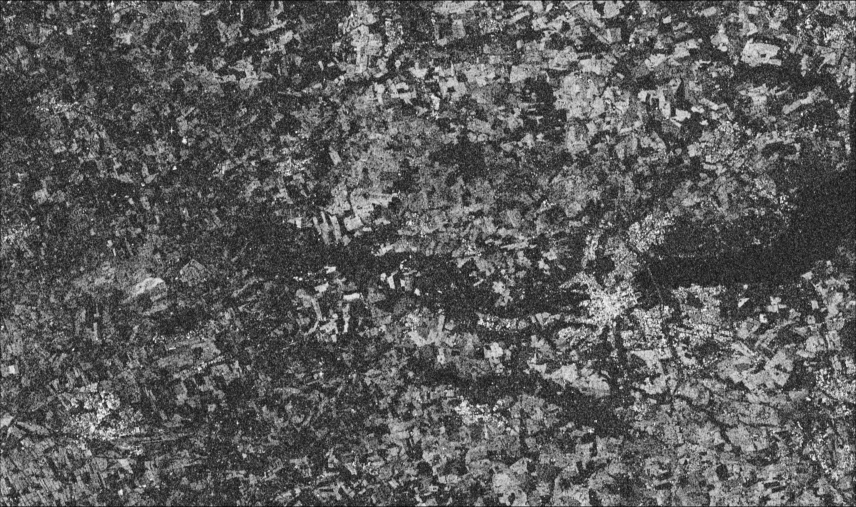

In [32]:
Gray.(abs.(complex_coherence))

# Mosaic Subswaths

In [79]:
master_folder = "/home/data/simon/data/117_jutlandS_autumn2019/S1A_IW_SLC__1SDV_20190929T170932_20190929T170959_029239_035263_C3F9.SAFE"
slave_folder = "/home/data/simon/data/117_jutlandS_autumn2019/S1A_IW_SLC__1SDV_20191011T170932_20191011T170959_029414_035865_06AB.SAFE"

#dem
dem_path = "/home/data/simon/DEM/denmark.jld";

# pod
master_pod_path = Load.pod_path(master_folder,"/home/data/simon/POE")
slave_pod_path = Load.pod_path(slave_folder,"/home/data/simon/POE");

In [80]:
polarization = "VV"

# Paths 
data_path2, meta_path2, cal_path2 = Load.slc_paths(master_folder, polarization, 2)
data_path3, meta_path3, cal_path3 = Load.slc_paths(master_folder, polarization, 3);


In [81]:
meta2 = Load.slc_meta(meta_path2);
meta3 = Load.slc_meta(meta_path3);

In [82]:
large_view = [8004:10200,18000:30000]

2-element Array{UnitRange{Int64},1}:
 8004:10200 
 18000:30000

In [84]:
view_first,view_second,delta_line,delta_sample =split_large_view(large_view,meta2,meta3);

In [86]:
data_first = Load.slc_data(data_path2,view_first);
data_first,mosaic_view_first_out = SlcUtil.mosaic(data_first,view_first,meta2 )
data_second = Load.slc_data(data_path3,view_second);
data_second,mosaic_view_second_out = SlcUtil.mosaic(data_second,view_second,meta3);

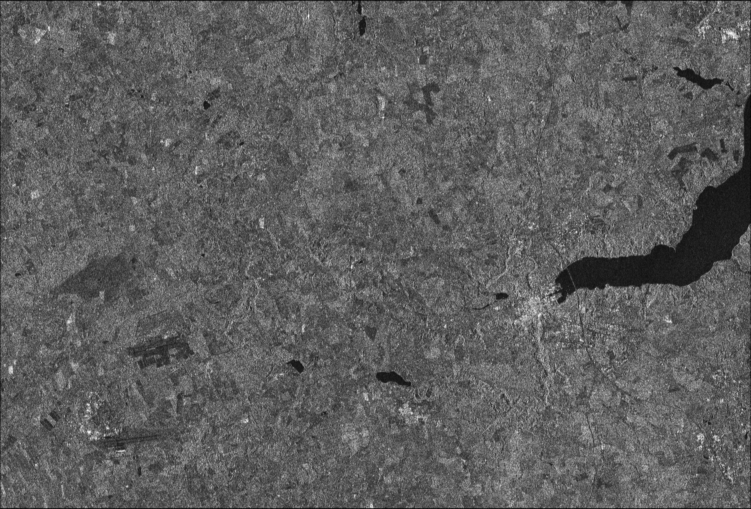

In [87]:
swath_mosaic= hcat(data_first,data_second);
SlcUtil.show_img(swath_mosaic)[:,1:4:end]

# Skrald

In [66]:
master_view = [4004:7200,18000:3000]
test = SlcUtil.get_mosaic_view(meta_test,master_view)

(3667:6528, 18000:17999)

In [68]:
large_view = [4004:7200,18000:30000]
meta_first = meta2
meta_second = meta3;

In [102]:
using Dates

In [160]:
function round_2_int(float_number,tol=0.1)
    res = round(Int64,float_number)
    @assert abs(res-float_number)<tol "Rounding not within tolerance"
return res
end

round_2_int (generic function with 2 methods)

In [161]:
inv_range_pixel_spacing*delta_r0

23856.999999999996

In [162]:
c = 299792458
azimuth_frequency =  meta_first["azimuth_frequency"]
inv_range_pixel_spacing = (2*meta_first["range_sampling_rate"])/c
delta_r0 = (meta_second["slant_range_time"]-meta_first["slant_range_time"])*c/2
delta_sample = inv_range_pixel_spacing*delta_r0

delta_sample = round_2_int(inv_range_pixel_spacing*delta_r0)

over_lap = meta_first["samples_per_burst"]-delta_sample +1

delta_minus = 300
delta_plus = over_lap - delta_minus


view_first = large_view[1],large_view[2].start:(meta_first["samples_per_burst"]-delta_minus)

mosaic_view_first = SlcUtil.get_mosaic_view(meta_first,view_first)


detlta_t0 = convert(Second,(meta_first["t_0"]-meta_second["t_0"]) ).value

line_t_first_start =  (mosaic_view_first[1].start-1)/azimuth_frequency+meta_first["t_start"]
line_second_start = round_2_int(1 + ((line_t_first_start+detlta_t0)-meta_second["t_start"])*azimuth_frequency)

line_t_first_stop =  (mosaic_view_first[1].stop-1)/azimuth_frequency+meta_first["t_start"]
line_second_stop= round_2_int(1 + ((line_t_first_stop+detlta_t0)-meta_second["t_start"])*azimuth_frequency)


mosaic_view_second = [line_second_start:line_second_stop,
                    (1+delta_plus): (large_view[2].stop - delta_sample+1)]

view_second =moasic2normal_view(mosaic_view_second,meta_second)


2-element Array{UnitRange{Int64},1}:
 3547:6758
 1802:6144

In [173]:
view_first,view_second =split_large_view(large_view,meta_first,meta_second);

In [174]:
data_first = Load.slc_data(data_path2,view_first);
data_first,mosaic_view_first_out = SlcUtil.mosaic(data_first,view_first,meta_first)
data_second = Load.slc_data(data_path3,view_second);
data_second,mosaic_view_second_out = SlcUtil.mosaic(data_second,view_second,meta_second);

In [175]:
mosaic_view_second,mosaic_view_second_out

(UnitRange{Int64}[3201:6062, 1802:6144], (3201:6062, 1802:6144))

In [176]:
mosaic_view_first,mosaic_view_first_out

((3667:6528, 18000:25657), (3667:6528, 18000:25657))

In [177]:
size(data_first),size(data_second)

((2862, 7658), (2862, 4343))

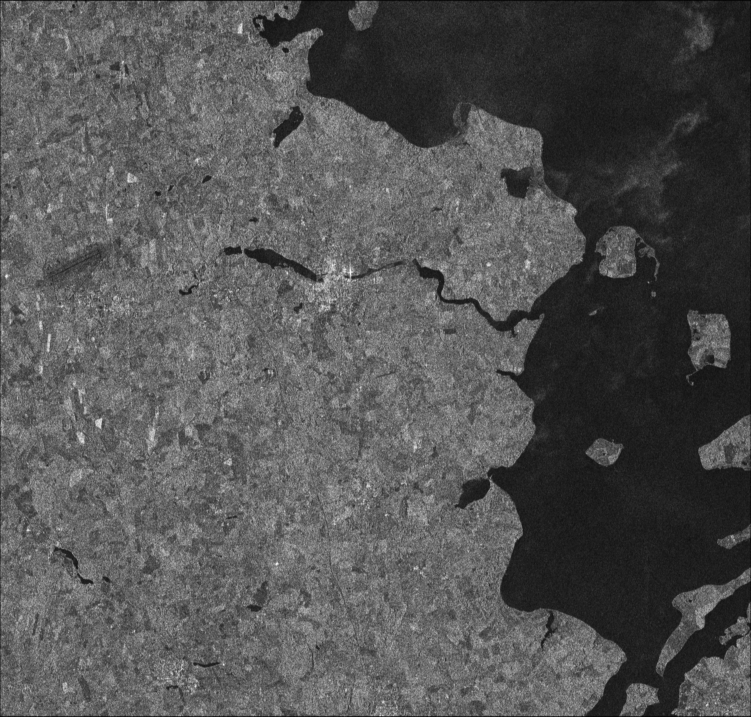

In [178]:
swath_mosaic= hcat(data_first,data_second);
SlcUtil.show_img(swath_mosaic)[:,1:4:end]

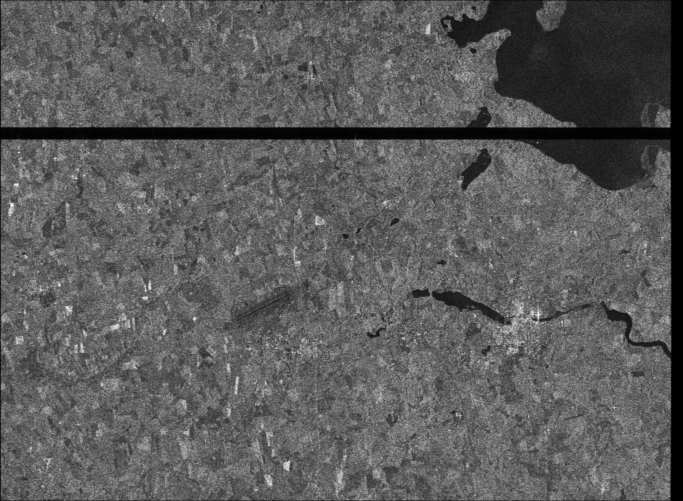

In [59]:
master_view = [4000:6000,15000:25900]
data2 = Load.slc_data(data_path2,master_view);
SlcUtil.show_img(data2)[:,1:4:end]

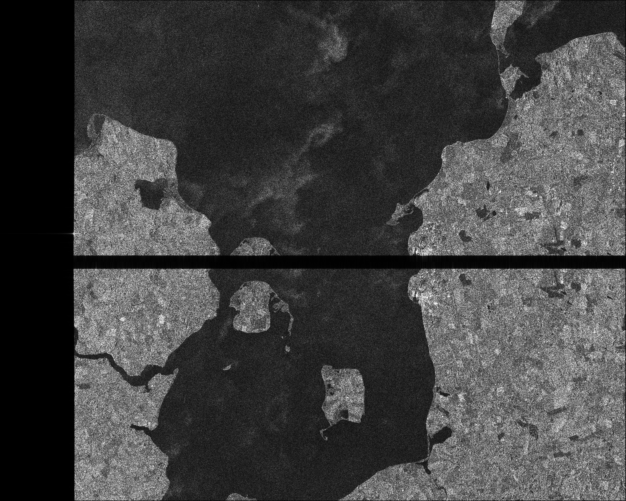

In [61]:
master_view = [3500:5500,1:10000]
data3 = Load.slc_data(data_path3,master_view);
SlcUtil.show_img(data3)[:,1:4:end]

In [3]:
master_folder = "/home/data/simon/data/117_jutlandS_autumn2019/S1A_IW_SLC__1SDV_20190929T170932_20190929T170959_029239_035263_C3F9.SAFE"
slave_folder = "/home/data/simon/data/117_jutlandS_autumn2019/S1A_IW_SLC__1SDV_20191011T170932_20191011T170959_029414_035865_06AB.SAFE"

#dem
dem_path = "/home/data/simon/DEM/denmark.jld";

# pod
master_pod_path = Load.pod_path(master_folder,"/home/data/simon/POE")
slave_pod_path = Load.pod_path(slave_folder,"/home/data/simon/POE");

In [4]:
polarization = "VV"
subswath = 3

# Paths 
master_data_path, master_meta_path, master_cal_path = Load.slc_paths(master_folder, polarization, subswath)
slave_data_path, slave_meta_path, slave_cal_path = Load.slc_paths(slave_folder, polarization, subswath);

In [5]:
master_view = [8000:10000,1200:6000]

2-element Array{UnitRange{Int64},1}:
 8000:10000
 1200:6000 

In [6]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [7]:
pad = 0.1
dem = JLD.load(dem_path);
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
idx1 =(latlon_window[1][1] - pad) .<dem["lat"].< (latlon_window[1][2] + pad)
idx2 =(latlon_window[2][1] - pad) .<dem["lon"].< (latlon_window[2][2] + pad)
dem = (dem["lat"][idx1], dem["lon"][idx2], dem["height"][idx1,idx2]);
dem[3][dem[3].<0] .= 40;

In [8]:
slave_data,flat,lut =  coregister_slave(master_view,slave_data_path,meta,precise_orbit,dem)
slave_data,mosaic_view = SlcUtil.mosaic(slave_data,master_view,meta[1]);
flat,mosaic_view = SlcUtil.mosaic(flat,master_view,meta[1]);

master_data = Load.slc_data(master_data_path,master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data,master_view,meta[1]);

In [9]:
kernel = ones(4,14)
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, slave_data, flat, kernel, mosaic_view);

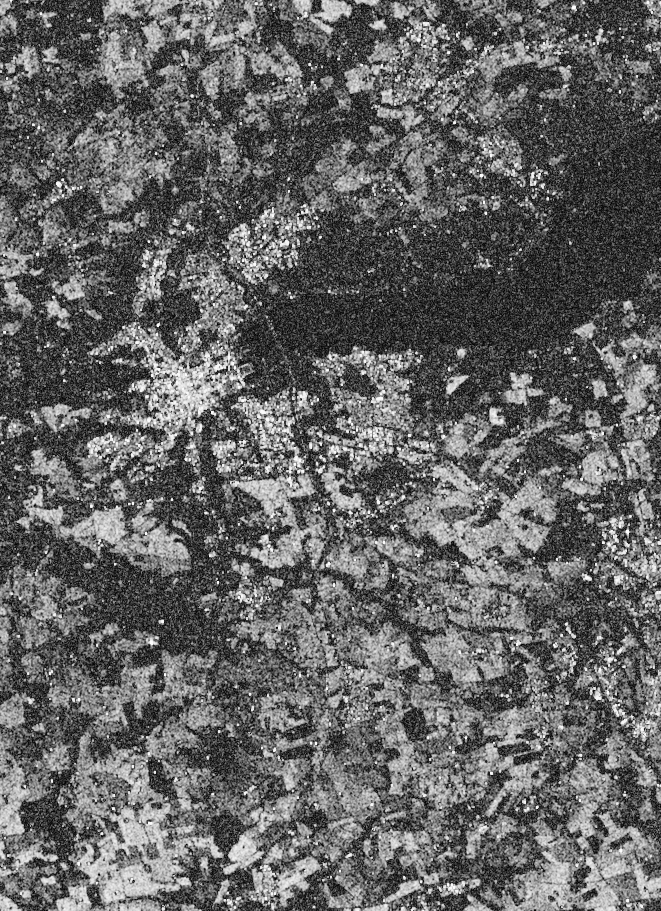

In [10]:
coherence_img = Gray.(abs.(complex_coherence[1:2:end,150:7:end]))

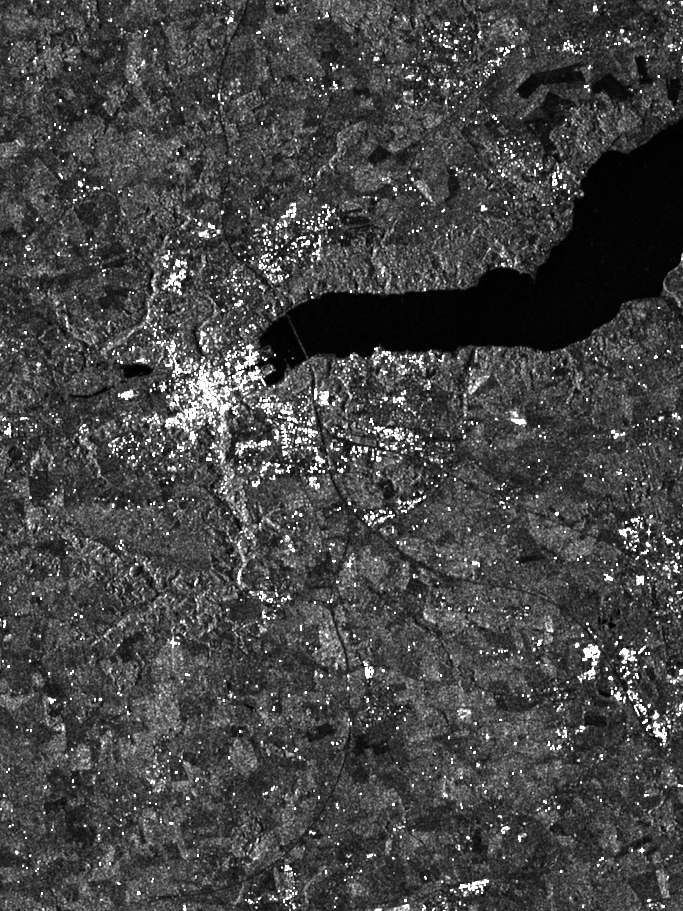

In [11]:
intensity = SlcUtil.show_img(master_intensity[1:2:end,1:7:end].-minimum(minimum(master_intensity[1:2:end,1:7:end])))

In [12]:
2+4

6